In [1]:
import pandas as pd
from sqlalchemy import create_engine
import collections
import seaborn as sns
import json
#from config import db_password

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
file_loc = "resources/flights.csv"
df = pd.read_csv(file_loc, low_memory=False)
df.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(len(df.index))

5819079


In [4]:
# drop all rows with cancelled flights

df = df.drop(df[df['CANCELLED'] == 1].index)
df = df.drop(df[df['DIVERTED'] == 1].index)

# Drop year: data is from 2015, 
# drop cancelled and diverted rows / columns as we are concerned with flights that were completed, with a delay time
# Departure time: predicting delay, having sceduled time and departure time will be giving the answer to the ml model
# Linear dependancy, drop redundant columns 
#     SCHEDULED_DEPARTURE - DEPARTURE_TIME = DEPARTURE_DELAY   drop DEPARTURE_TIME
#     TAXI_OUT + WHEELS_OFF + SCHEDULED_TIME = ELAPSED_TIME    drop TAXI_OUT, WHEELS_OFF, SCHEDULED_TIME
#     ARRIVAL_DELAY = AIR_SYSTEM_DELAY + SECURITY_DELAY + AIRLINE_DELAY + LATE_AIRCRAFT_DELAY + WEATHER_DELAY      drop ?

df.drop(columns=['YEAR', 'CANCELLED', 'CANCELLATION_REASON', 'DIVERTED', 'DEPARTURE_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME'], inplace=True)



df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,1,1,4,AS,98,N407AS,ANC,SEA,5,-11.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,NaN,NaN,NaN,NaN,NaN
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,-8.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,NaN,NaN,NaN,NaN,NaN
2,1,1,4,US,840,N171US,SFO,CLT,20,-2.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,NaN,NaN,NaN,NaN,NaN
3,1,1,4,AA,258,N3HYAA,LAX,MIA,20,-5.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,NaN,NaN,NaN,NaN,NaN
4,1,1,4,AS,135,N527AS,SEA,ANC,25,-1.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,NaN,NaN,NaN,NaN,NaN


In [5]:
# only keep trips to/from airports with over 20000 visits

visits_totals = df['ORIGIN_AIRPORT'].value_counts()
airport_dict = {}
for i in range(len(visits_totals)):
    if visits_totals[i] > 20000:
        airport_dict[visits_totals.index[i]] = i+1  # i+1 to prevent a 0 for encoding later on 

# Creates a dictionary of airport codes, with a value for encoding, alphabetized for later use with project visualizations
sorted_airport_dict = collections.OrderedDict(sorted(airport_dict.items()))

In [6]:
# Remove all rows with airports not in airport_dict (only concerned with popular locations)

# Get list of airports to be removed
all_airpots = visits_totals.index
kept_airports = airport_dict.keys()
to_drop = list(all_airpots)
for element in kept_airports:
    to_drop.remove(element)


to_drop.append('13930')
to_drop.append('10397')
to_drop.append('11298')

for airport in to_drop:
    df.drop(df[df['ORIGIN_AIRPORT'] == airport].index, inplace=True)
    df.drop(df[df['DESTINATION_AIRPORT'] == airport].index, inplace=True)
    #print(airport)
    

In [7]:
# Get dictionary for encoding AIRLINE
airlines_totals = df['AIRLINE'].value_counts()
airlines_dict = {}
for i in range(len(airlines_totals)):
    airlines_dict[airlines_totals.index[i]] = i+1  # i+1 to prevent a 0 for encoding later on 

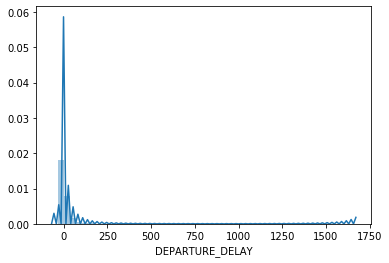

In [8]:
# To check the Distribution of departure delays
sns.distplot(df['DEPARTURE_DELAY'])


# large delays are likely from outside sources, remove delays greater than two hours
df.drop(df[df['DEPARTURE_DELAY'] >= 60].index, inplace=True)


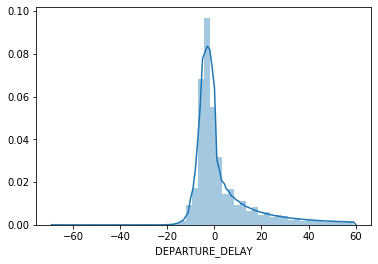

In [9]:
# To check the Distribution of departure delays
sns.distplot(df['DEPARTURE_DELAY'])

In [10]:
# Export airport dictionaries to CSV

# Saving airport dictionary
airport_file = open("resources/airport_dict.json", "w")
json.dump(airport_dict, airport_file)
airport_file.close()

# TO read
#airport_file = open("resources/airport_dict.json", "r")
#output = airport_file.read()
#print(output)


# Saving airline dictionary
airline_file = open("resources/airline_dict.json", "w")
json.dump(airlines_dict, airline_file)
airline_file.close()

In [11]:
df.head(3)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,-8.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,NaN,NaN,NaN,NaN,NaN
2,1,1,4,US,840,N171US,SFO,CLT,20,-2.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,NaN,NaN,NaN,NaN,NaN
3,1,1,4,AA,258,N3HYAA,LAX,MIA,20,-5.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,NaN,NaN,NaN,NaN,NaN


In [12]:
# Randomize dataset
df = df.sample(frac=1, random_state=1)

In [13]:
df.head(3)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_DELAY,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
1090018,3,12,4,UA,248,N842UA,IAH,SNA,1812,35.0,214.0,180.0,1346,2013.0,8.0,1956,2021.0,25.0,0.0,0.0,25.0,0.0,0.0
1487728,4,6,1,WN,557,N629SW,MSP,ATL,930,2.0,141.0,121.0,907,1246.0,7.0,1300,1253.0,-7.0,NaN,NaN,NaN,NaN,NaN
4248474,9,22,2,AS,36,N478AS,SEA,MSP,1000,-4.0,183.0,164.0,1399,1455.0,4.0,1515,1459.0,-16.0,NaN,NaN,NaN,NaN,NaN


In [14]:
print(len(df.index))

3160901


In [15]:
#Export cleaned dataset


df.to_csv("resources/flights_cleaned.csv")

In [16]:
df.isna().sum()

MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER                  0
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_DELAY              0
ELAPSED_TIME                 0
AIR_TIME                     0
DISTANCE                     0
WHEELS_ON                    0
TAXI_IN                      0
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME                 0
ARRIVAL_DELAY                0
AIR_SYSTEM_DELAY       2701998
SECURITY_DELAY         2701998
AIRLINE_DELAY          2701998
LATE_AIRCRAFT_DELAY    2701998
WEATHER_DELAY          2701998
dtype: int64